In [816]:
# imports
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD, Adam
import itertools
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import fbeta_score

In [849]:
# globals
path = '/Users/tomer.gofman/Downloads/data_for_project - tagged_data_for_model.csv'

In [850]:
# Deep ANT Hyper Paramaters
w = 72                # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 1              # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

In [851]:
def anomaly_detector_for_1_sample(prediction_val, ground_truth_val, percentage_diff_threshold=0.4):
    """
    Detects anomalies by checking if the absolute percentage difference between predicted 
    and actual values exceeds a given threshold.

    Args:
        prediction_val (float): Predicted value.
        ground_truth_val (float): Actual observed value.
        percentage_diff_threshold (float, optional): Anomaly threshold (default: 0.4 or 40%).

    Returns:
        int: 1 if an anomaly is detected, else 0.
    """
    dist = np.abs(ground_truth_val - prediction_val)
    percentage_dist = dist / ground_truth_val
    return 1 if percentage_dist > percentage_diff_threshold else 0

In [852]:
def read_data(path):
    df = pd.read_csv(path)
    return df

In [853]:
df = read_data(path)

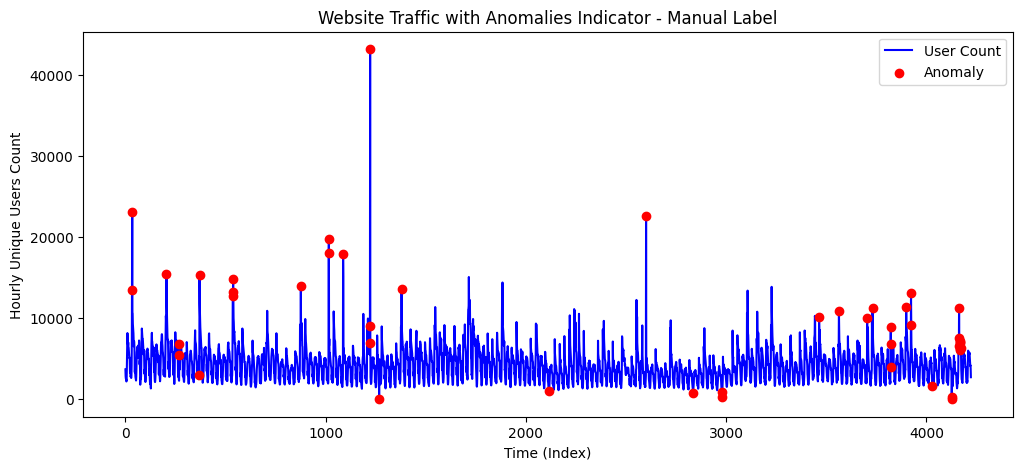

In [854]:
# Plot the data

# Plot user count over time
plt.figure(figsize=(12, 5))
plt.plot(df['user_count'], label='User Count', color='blue')

# Highlight anomalies with red dots
anomalies = df[df['is_anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['user_count'], color='red', label='Anomaly', zorder=3)

# Labels and legend
plt.title('Website Traffic with Anomalies Indicator - Manual Label')
plt.xlabel('Time (Index)')
plt.ylabel('Hourly Unique Users Count')
plt.legend()
plt.show()

In [855]:
"""Data preprocessing"""
# split a univariate sequence into samples
def split_sequence(sequence):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + w
		out_end_ix = end_ix + p_w
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = list(df['user_count'])
# define train, validation & train split
train_end_idx = 0.65
val_end_idx = 0.79

train_seq = raw_seq[:int(len(raw_seq)*train_end_idx)]
validation_seq = raw_seq[int(len(raw_seq)*train_end_idx):int(len(raw_seq)*val_end_idx)]
test_seq = raw_seq[int(len(raw_seq)*val_end_idx):]
# split into samples and split to train, validation and test
batch_sample_train, batch_label_train = split_sequence(train_seq)
batch_sample_val, batch_label_val = split_sequence(validation_seq)
batch_sample_test, batch_label_test = split_sequence(test_seq)

# reshape from [samples, timesteps] into [samples, timesteps, features]
batch_sample_train = batch_sample_train.reshape((batch_sample_train.shape[0], batch_sample_train.shape[1], n_features))
batch_sample_val = batch_sample_val.reshape((batch_sample_val.shape[0], batch_sample_val.shape[1], n_features))
batch_sample_test = batch_sample_test.reshape((batch_sample_test.shape[0], batch_sample_test.shape[1], n_features))

In [856]:


def create_model(learning_rate, loss_function, optimizer_type, num_filt_1, num_filt_2, kernel_size, conv_strides, pool_size_1, pool_size_2, dropout_rate, num_nrn_dl, num_nrn_ol):
    model = Sequential()
    
    # Convolutional Layer #1
    model.add(Conv1D(filters=num_filt_1,
                     kernel_size=kernel_size,
                     strides=conv_strides,
                     padding='valid',
                     activation='relu',
                     input_shape=(batch_sample_train.shape[1], batch_sample_train.shape[2])))
    
    # Pooling Layer #1
    model.add(MaxPooling1D(pool_size=pool_size_1))
    
    # Convolutional Layer #2
    model.add(Conv1D(filters=num_filt_2,
                     kernel_size=kernel_size,
                     strides=conv_strides,
                     padding='valid',
                     activation='relu'))
    
    # Max Pooling Layer #2
    model.add(MaxPooling1D(pool_size=pool_size_2))
    
    # Flatten Layer
    model.add(Flatten())
    
    # Dense Layer
    model.add(Dense(units=num_nrn_dl, activation='relu'))
    
    # Dropout Layer
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(units=num_nrn_ol))
    
    optimizer = Adam(learning_rate=learning_rate) if optimizer_type == 'adam' else SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function)
    return model

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.0001, 0.00002, 0.00005],
    'loss_function': ['mae','mse'],
    'optimizer_type': ['sgd','adam'],
    'num_filt_1': [16, 32],
    'num_filt_2': [32, 64],
    'kernel_size': [3, 5],
    'conv_strides': [1],
    'pool_size_1': [2],
    'pool_size_2': [2],
    'dropout_rate': [0.4, 0.5, 0.6],
    'num_nrn_dl': [1024],
    'num_nrn_ol': [1]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))

best_loss = float('inf')
best_model = None
best_params = None

# Run grid search
for params in param_combinations:
    lr, loss,optimizer_type, num_filt_1, num_filt_2, kernel, conv_strides, pool_1, pool_2, dropout, num_nrn_dl, num_nrn_ol = params
    print(f"Training with: lr={lr}, optimizer={optimizer_type}, loss={loss}, num_filt_1={num_filt_1}, num_filt_2={num_filt_2}, kernel={kernel}, dropout={dropout}")

    model = create_model(lr, loss, optimizer_type, num_filt_1, num_filt_2, kernel, conv_strides, pool_1, pool_2, dropout, num_nrn_dl, num_nrn_ol)


    history = model.fit(
        batch_sample_train, batch_label_train, 
        validation_data=(batch_sample_val, batch_label_val), 
        epochs=30, batch_size=32, verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    
    val_loss = min(history.history['val_loss'])
    print(f"Validation Loss: {val_loss}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_params = params

print(f"Best model parameters: {best_params} with validation loss: {best_loss}")

Best model parameters: (0.0001, 'mae', 'adam', 32, 32, 5, 1, 2, 2, 0.4, 1024, 1) with validation loss: 490.2438659667969


In [857]:
# run model based on best model
model = create_model(0.0001, 'mae', 'adam', 32, 32, 5, 1, 2, 2, 0.4, 1024, 1)
history_cnn = model.fit(
        batch_sample_train, batch_label_train, 
        validation_data=(batch_sample_val, batch_label_val), 
        epochs=30, batch_size=32, verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [858]:
# Predict on test data
yhat = model.predict(batch_sample_test, verbose=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


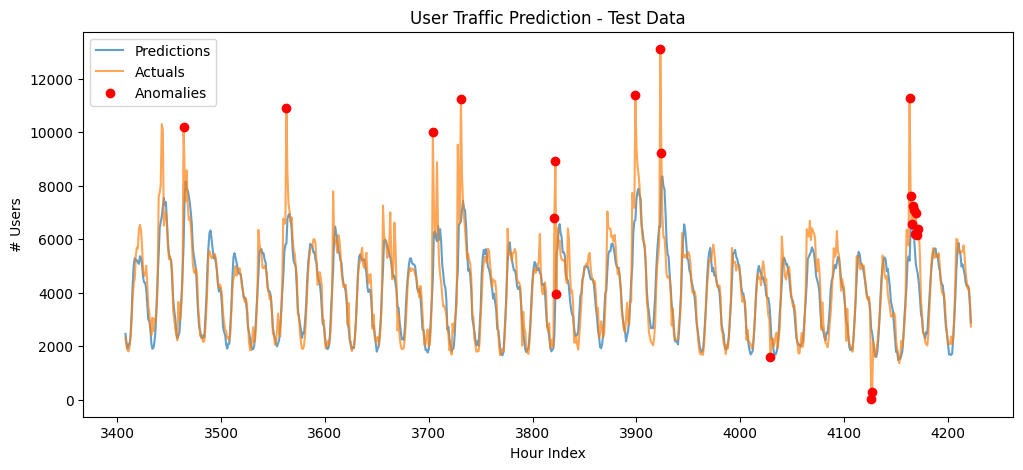

In [859]:
# Extract the last part of df corresponding to test_seq
test_data = df.iloc[int(len(df) * val_end_idx+w):].copy()

# Ensure `hour_index` aligns properly with predictions
hour_index = test_data['hour_index'].values

# Find the first valid hour index (e.g., 3443) and remove all earlier timestamps
first_valid_hour_index = min(hour_index)

# Filter both test_data and hour_index to start exactly from `first_valid_hour_index`
test_data = test_data[test_data['hour_index'] >= first_valid_hour_index].copy()
hour_index = test_data['hour_index'].values  # Re-align the hour index

# Flatten yhat and batch_label_test for alignment
yhat = yhat.flatten()
batch_label_test = batch_label_test[:len(yhat)].flatten()  # Ensure same length

fig_predict = plt.figure(figsize=(12, 5))  # Adjusted figure size

# Plot predictions and actual values using correctly aligned hour_index
plt.plot(hour_index, yhat, label="Predictions", linestyle='-', alpha=0.7)
plt.plot(hour_index, batch_label_test, label="Actuals", linestyle='-', alpha=0.7)

# Find anomaly positions within the aligned test_data
anomaly_indices = test_data.loc[test_data['is_anomaly'] == 1, 'hour_index'].values
anomaly_values = test_data.loc[test_data['is_anomaly'] == 1, 'user_count'].values

# Ensure only anomalies in the predicted range are included
valid_anomaly_mask = test_data['hour_index'].isin(hour_index)
filtered_anomaly_indices = test_data.loc[valid_anomaly_mask & (test_data['is_anomaly'] == 1), 'hour_index'].values
filtered_anomaly_values = test_data.loc[valid_anomaly_mask & (test_data['is_anomaly'] == 1), 'user_count'].values

# Plot anomalies as red dots
#plt.scatter(filtered_anomaly_indices, filtered_anomaly_values, color='red', label="Anomalies", marker='o', zorder=3)
plt.scatter(anomaly_indices, anomaly_values, color='red', label="Anomalies", marker='o', zorder=3)

# Formatting
plt.title(f'User Traffic Prediction - Test Data')
plt.ylabel('# Users')
plt.xlabel('Hour Index')
plt.legend(loc='upper left')
plt.show()


In [860]:
# Apply anomaly detection only on the last len(yhat) timestamps
test_data.loc[test_data.index[-len(yhat):], 'is_anomaly_according_to_model'] = [
    anomaly_detector_for_1_sample(pred, true)
    for pred, true in zip(yhat.flatten(), test_data['user_count'].iloc[-len(yhat):])
]

# Ensure test_data only contains valid hour indices
test_data = test_data[test_data['hour_index'].isin(hour_index)]

# Add predicted user count column to test_data
test_data.loc[test_data.index[-len(yhat):], 'predicted_user_count'] = yhat.flatten()

# Extract only the relevant rows for evaluation
aligned_test_data = test_data.iloc[-len(yhat):]

# Compute F2 score using only the predicted range
y_true = aligned_test_data['is_anomaly'].values
y_pred_model = aligned_test_data['is_anomaly_according_to_model'].values
y_pred_company = aligned_test_data['was_tagged_as_anomaly'].values

f2_score_model = fbeta_score(y_true, y_pred_model, beta=2)
f2_score_company = fbeta_score(y_true, y_pred_company, beta=2)

# Print results
print(f"F2 Score (CNN Model): {f2_score_model}")
print(f"F2 Score (Company Model): {f2_score_company}")


F2 Score (CNN Model): 0.5882352941176471
F2 Score (Company Model): 0.29411764705882354


# Ploting Results

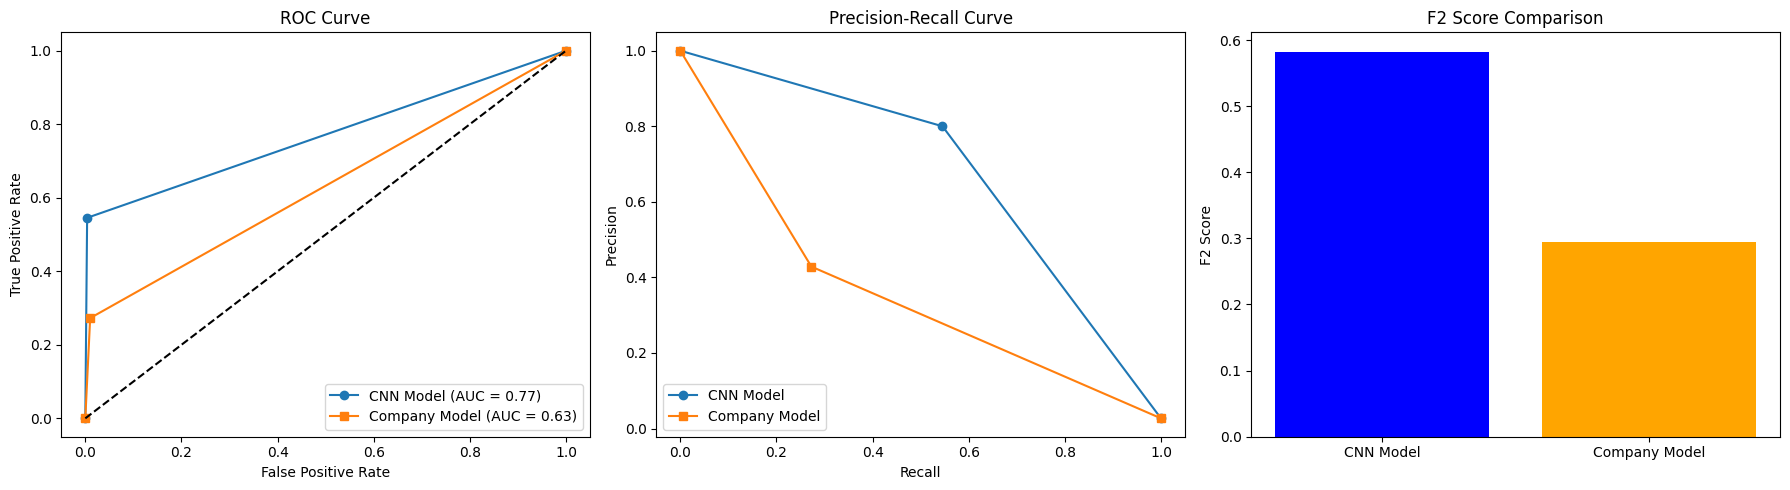

In [829]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Ensure predictions are probabilities (for ROC & PR curves)
y_pred_model_prob = np.clip(y_pred_model, 0, 1)  # Ensure values are within [0,1]
y_pred_company_prob = np.clip(y_pred_company, 0, 1)

# Compute ROC Curve
fpr_model, tpr_model, _ = roc_curve(y_true, y_pred_model_prob)
fpr_company, tpr_company, _ = roc_curve(y_true, y_pred_company_prob)

# Compute AUC (Area Under Curve)
roc_auc_model = auc(fpr_model, tpr_model)
roc_auc_company = auc(fpr_company, tpr_company)

# Compute Precision-Recall Curve
precision_model, recall_model, _ = precision_recall_curve(y_true, y_pred_model_prob)
precision_company, recall_company, _ = precision_recall_curve(y_true, y_pred_company_prob)

# Create plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot ROC Curve
axs[0].plot(fpr_model, tpr_model, label=f'CNN Model (AUC = {roc_auc_model:.2f})', linestyle='-', marker='o')
axs[0].plot(fpr_company, tpr_company, label=f'Company Model (AUC = {roc_auc_company:.2f})', linestyle='-', marker='s')
axs[0].plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Plot Precision-Recall Curve
axs[1].plot(recall_model, precision_model, label="CNN Model", linestyle='-', marker='o')
axs[1].plot(recall_company, precision_company, label="Company Model", linestyle='-', marker='s')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

# Plot F2 Score Comparison
axs[2].bar(['CNN Model', 'Company Model'], [f2_score_model, f2_score_company], color=['blue', 'orange'])
axs[2].set_ylabel('F2 Score')
axs[2].set_title('F2 Score Comparison')

# Show plots
plt.tight_layout()
plt.show()


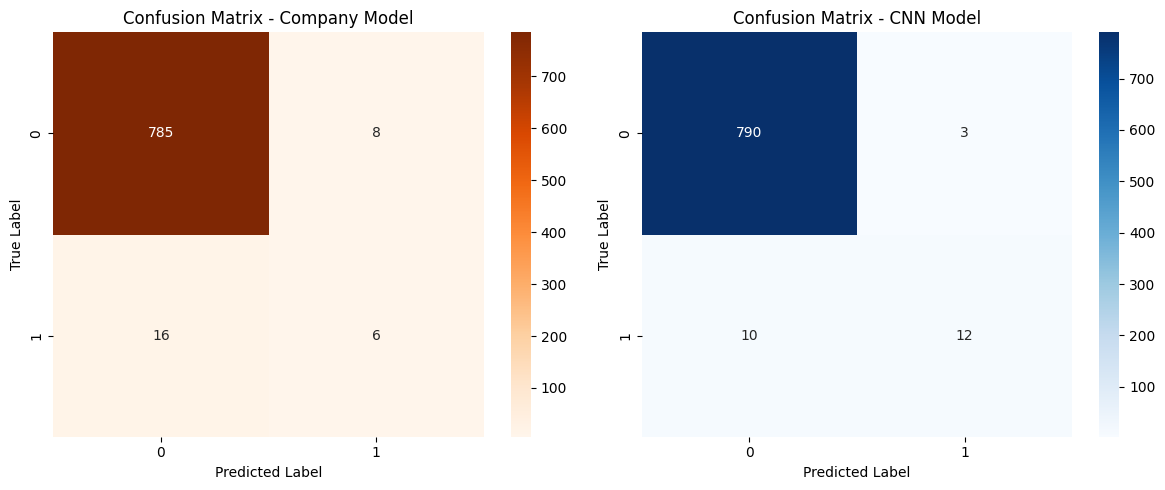

In [830]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrices
conf_matrix_model = confusion_matrix(y_true, y_pred_model)
conf_matrix_company = confusion_matrix(y_true, y_pred_company)

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# Confusion Matrix for Company Model
sns.heatmap(conf_matrix_company, annot=True, fmt="d", cmap="Oranges", ax=axs[0])
axs[0].set_title("Confusion Matrix - Company Model")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Confusion Matrix for CNN Model
sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Confusion Matrix - CNN Model")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")



# # Bar Chart for F2 Score Comparison
# axs[2].bar(['CNN Model', 'Company Model'], [f2_score_model, f2_score_company], color=['blue', 'orange'])
# axs[2].set_ylabel('F2 Score')
# axs[2].set_title('F2 Score Comparison')

# Show the plots
plt.tight_layout()
plt.show()


# Adding Attention

# V1 = BahdanauAttention

In [865]:
import tensorflow as tf
from keras.layers import Layer

class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # Query: Decoder hidden state
        # Values: Encoder output

        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [866]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.models import Model

# Define CNN with Bahdanau Attention
def create_cnn_attention_model():
    input_layer = Input(shape=(batch_sample_train.shape[1], batch_sample_train.shape[2]))

    # CNN Layers
    conv1 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # Flatten Layer
    flattened = Flatten()(pool2)

    # Dense Layer
    dense = Dense(1024, activation='relu')(flattened)
    dropout = Dropout(0.4)(dense)  # Dropout set to 0.4

    # Output Layer
    output_layer = Dense(1)(dropout)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mae')

    return model

In [881]:
# Train the original CNN model
from keras.callbacks import ReduceLROnPlateau

# Learning rate scheduler to avoid overfitting
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_cnn_attention = cnn_attention_model.fit(batch_sample_train, batch_label_train, 
                        validation_data=(batch_sample_val, batch_label_val), 
                        epochs=50, batch_size=64, verbose=1, 
                        callbacks=[lr_scheduler])

# Train the CNN+Attention Model
# Predict on test data



Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 721.5125 - val_loss: 601.9391 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 717.8450 - val_loss: 585.9578 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 722.4547 - val_loss: 600.4463 - learning_rate: 1.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 733.9020 - val_loss: 597.4497 - learning_rate: 1.0000e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 712.4844 - val_loss: 600.5303 - learning_rate: 1.0000e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 771.1798 - val_loss: 604.5179 - learning_rate: 5.0000e-05
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 700.9331 - val_loss: 600.2983 - learning_rate: 5.0000e-05
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 729.3699 - val_loss: 596.7992 - learning_rate: 5.0000e-05
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 732.6470 - val

In [882]:
yhat_attention = cnn_attention_model.predict(batch_sample_test)

# Evaluate performance using F2 Score
y_pred_attention = [anomaly_detector_for_1_sample(pred, true) for pred, true in zip(yhat_attention.flatten(), batch_label_test)]

f2_score_cnn = fbeta_score(test_data['is_anomaly'].values, y_pred_model, beta=2)
f2_score_attention = fbeta_score(test_data['is_anomaly'].values, y_pred_attention, beta=2)

print(f"F2 Score (CNN Model): {f2_score_cnn}")
print(f"F2 Score (CNN + Attention Model): {f2_score_attention}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
F2 Score (CNN Model): 0.5882352941176471
F2 Score (CNN + Attention Model): 0.5172413793103449


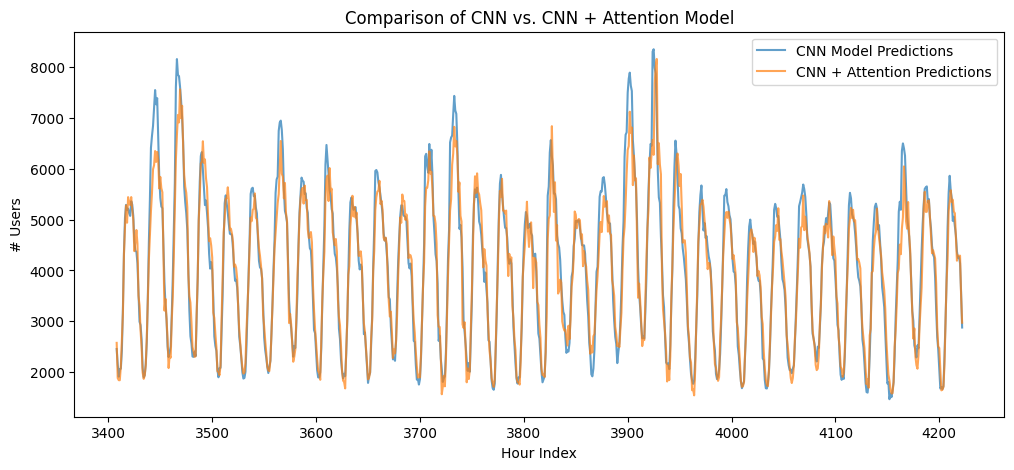

In [883]:
# Plot both models' predictions
plt.figure(figsize=(12, 5))
plt.plot(hour_index, yhat.flatten(), label="CNN Model Predictions", linestyle='-', alpha=0.7)
plt.plot(hour_index, yhat_attention.flatten(), label="CNN + Attention Predictions", linestyle='-', alpha=0.7)
#plt.plot(hour_index, batch_label_test.flatten(), label="Actual Values", linestyle='-', alpha=0.7)
#plt.scatter(filtered_anomaly_indices, filtered_anomaly_values, color='red', label="Anomalies", marker='o', zorder=3)

# Formatting
plt.title('Comparison of CNN vs. CNN + Attention Model')
plt.ylabel('# Users')
plt.xlabel('Hour Index')
plt.legend(loc='upper right')
plt.show()


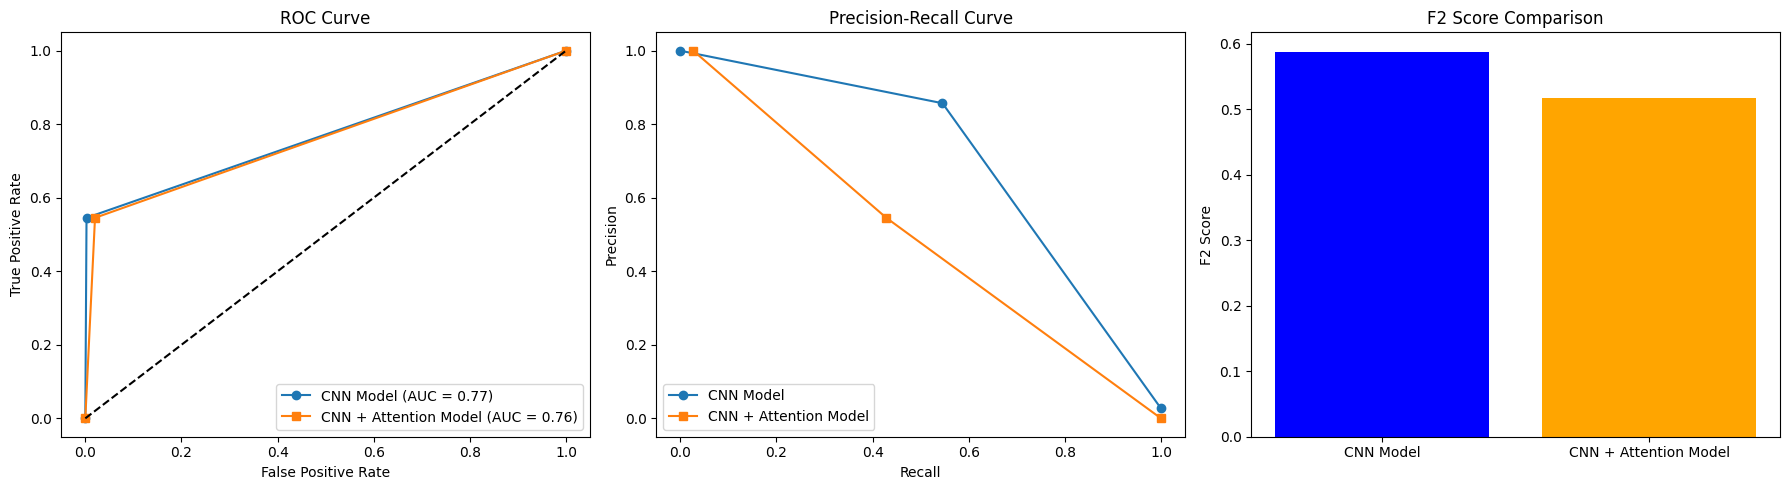

In [892]:
# Ensure predictions are probabilities (for ROC & PR curves)
y_pred_model_prob = np.clip(y_pred_model, 0, 1)  # Ensure values are within [0,1]
y_pred_attention_prob = np.clip(y_pred_attention, 0, 1)

# Compute ROC Curve
fpr_model, tpr_model, _ = roc_curve(y_true, y_pred_model_prob)
fpr_attention, tpr_attention, _ = roc_curve(y_true, y_pred_attention_prob)

# Compute AUC (Area Under Curve)
roc_auc_model = auc(fpr_model, tpr_model)
roc_auc_company = auc(fpr_attention, tpr_attention)

# Compute Precision-Recall Curve
precision_model, recall_model, _ = precision_recall_curve(y_true, y_pred_model_prob)
precision_attention, recall_attention, _ = precision_recall_curve(y_true, y_pred_attention_prob)

# Create plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot ROC Curve
axs[0].plot(fpr_model, tpr_model, label=f'CNN Model (AUC = {roc_auc_model:.2f})', linestyle='-', marker='o')
axs[0].plot(fpr_attention, tpr_attention, label=f'CNN + Attention Model (AUC = {roc_auc_company:.2f})', linestyle='-', marker='s')
axs[0].plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Plot Precision-Recall Curve
axs[1].plot(recall_model, precision_model, label="CNN Model", linestyle='-', marker='o')
axs[1].plot(precision_attention, recall_attention, label="CNN + Attention Model", linestyle='-', marker='s')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

# Plot F2 Score Comparison
axs[2].bar(['CNN Model', 'CNN + Attention Model'], [f2_score_model, f2_score_attention], color=['blue', 'orange'])
axs[2].set_ylabel('F2 Score')
axs[2].set_title('F2 Score Comparison')

# Show plots
plt.tight_layout()
plt.show()


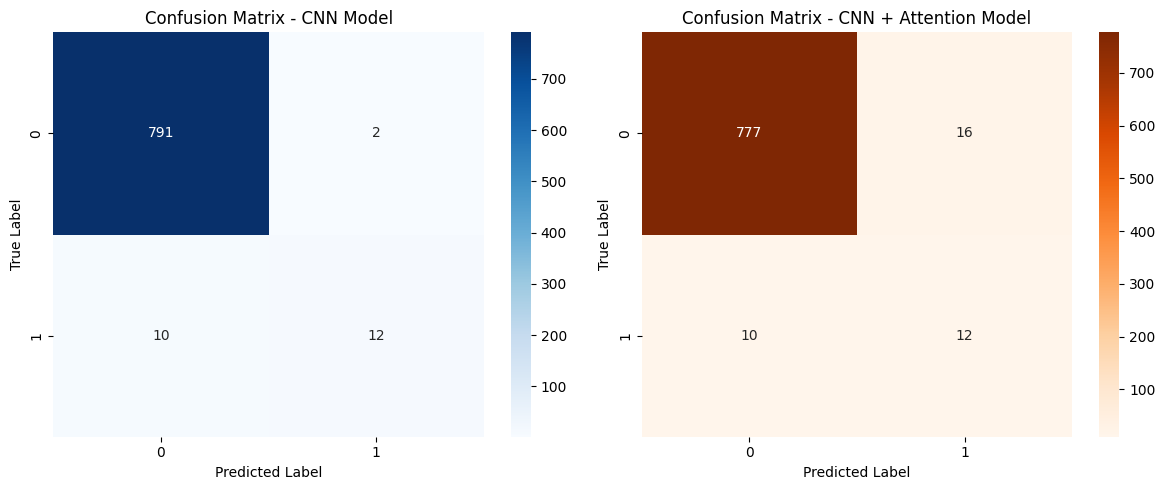

In [889]:
# Convert predictions to NumPy arrays if they are lists
y_pred_model = np.array(y_pred_model)
y_pred_attention = np.array(y_pred_attention)

# Convert predictions to binary (0/1) based on threshold
threshold = 0.5
y_pred_cnn_binary = (y_pred_model >= threshold).astype(int)
y_pred_attention_binary = (y_pred_attention >= threshold).astype(int)

# Compute confusion matrices
conf_matrix_cnn = confusion_matrix(y_true, y_pred_cnn_binary)
conf_matrix_attention = confusion_matrix(y_true, y_pred_attention_binary)

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for CNN Model
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Confusion Matrix - CNN Model")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Confusion Matrix for CNN + Attention Model
sns.heatmap(conf_matrix_attention, annot=True, fmt="d", cmap="Oranges", ax=axs[1])
axs[1].set_title("Confusion Matrix - CNN + Attention Model")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# Show the plots
plt.tight_layout()
plt.show()


# V2 - Self-Attention

In [861]:
import tensorflow as tf
from keras.layers import Layer, Multiply, Dense

class AttentionLayer(Layer):
    def __init__(self, units, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.W = Dense(units, activation='tanh')  # Learnable Weights
        self.V = Dense(1, activation='linear')  # Scalar Attention Scores

    def call(self, inputs):
        attention_scores = self.V(self.W(inputs))  # Compute attention scores
        attention_weights = tf.nn.softmax(attention_scores, axis=1)  # Normalize across time steps
        return Multiply()([inputs, attention_weights])  # Apply attention weights to inputs


from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, SGD

# CNN Model with Fixed Attention
def create_model_with_attention(learning_rate, loss_function, optimizer_type, num_filt_1, num_filt_2, kernel_size, 
                                conv_strides, pool_size_1, pool_size_2, dropout_rate, num_nrn_dl, num_nrn_ol):
    model = Sequential()
    
    # Convolutional Layer #1
    model.add(Conv1D(filters=num_filt_1, kernel_size=kernel_size, strides=conv_strides, 
                     padding='valid', activation='relu', input_shape=(batch_sample_train.shape[1], batch_sample_train.shape[2])))
    
    # Pooling Layer #1
    model.add(MaxPooling1D(pool_size=pool_size_1))

    # Convolutional Layer #2
    model.add(Conv1D(filters=num_filt_2, kernel_size=kernel_size, strides=conv_strides, padding='valid', activation='relu'))

    # Max Pooling Layer #2
    model.add(MaxPooling1D(pool_size=pool_size_2))
    
    # Apply Attention
    model.add(AttentionLayer(units=num_filt_2))  # Pass number of filters as attention units

    # Flatten Layer
    model.add(Flatten())
    
    # Dense Layer
    model.add(Dense(units=num_nrn_dl, activation='relu'))
    
    # Dropout Layer
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(units=num_nrn_ol))
    
    optimizer = Adam(learning_rate=learning_rate) if optimizer_type == 'adam' else SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function)
    
    return model


In [874]:
cnn_attention_model = create_model_with_attention(0.0001, 'mae', 'adam', 32, 32, 5, 1, 2, 2, 0.4, 1024, 1)

history_cnn_attention = cnn_attention_model.fit(
    batch_sample_train, batch_label_train,
    validation_data=(batch_sample_val, batch_label_val),
    epochs=30, batch_size=32, verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3447.9158 - val_loss: 1199.4712
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1201.7170 - val_loss: 828.1579
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 973.9866 - val_loss: 811.9218
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 959.0107 - val_loss: 787.9409
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 962.3904 - val_loss: 793.8980
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1026.1172 - val_loss: 793.2700
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 938.4711 - val_loss: 776.1345
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 901.7170 - val_loss: 742.9693
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 912.2343 - val_loss: 719.1164
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 849.2319 - val_loss: 712.9262
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 863.0736 - val_loss: 755.2161
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━

In [875]:
# Compute F2 Score for Self-Attention Model
y_pred_self_attention = cnn_self_attention_model.predict(batch_sample_test)
y_pred_self_attention_binary = (y_pred_self_attention >= threshold).astype(int)

f2_score_self_attention = fbeta_score(y_true, y_pred_self_attention_binary, beta=2)

print(f"F2 Score (CNN Model): {f2_score_model}")
print(f"F2 Score (CNN+Attention Model): {f2_score_attention}")
print(f"F2 Score (CNN+Self-Attention Model): {f2_score_self_attention}")


2025-02-22 21:33:44.466379: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at conv_ops.cc:61 : INVALID_ARGUMENT: Depth of input must be a multiple of depth of filter: 1 vs 8

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 640, in run_forever
File 

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
<stack traces unavailable>
Depth of input must be a multiple of depth of filter: 1 vs 8

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 640, in run_forever
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1992, in _run_once
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "/var/folders/wq/c3bzxc8j3f35scsh6vc4sxg40000gn/T/ipykernel_21906/1373358972.py", line 2, in <module>
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py", line 908, in __call__
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py", line 637, in call
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py", line 908, in __call__
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/conv1d.py", line 151, in call
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1305, in conv
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 329, in conv
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 317, in _conv_xla
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 304, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference__conv_xla_4694633[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[functional_4643_1/conv1d_1153_1/StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_4694728]

mework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py", line 637, in call
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py", line 908, in __call__
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/conv1d.py", line 151, in call
File "/Library/Frameworks/Pyth

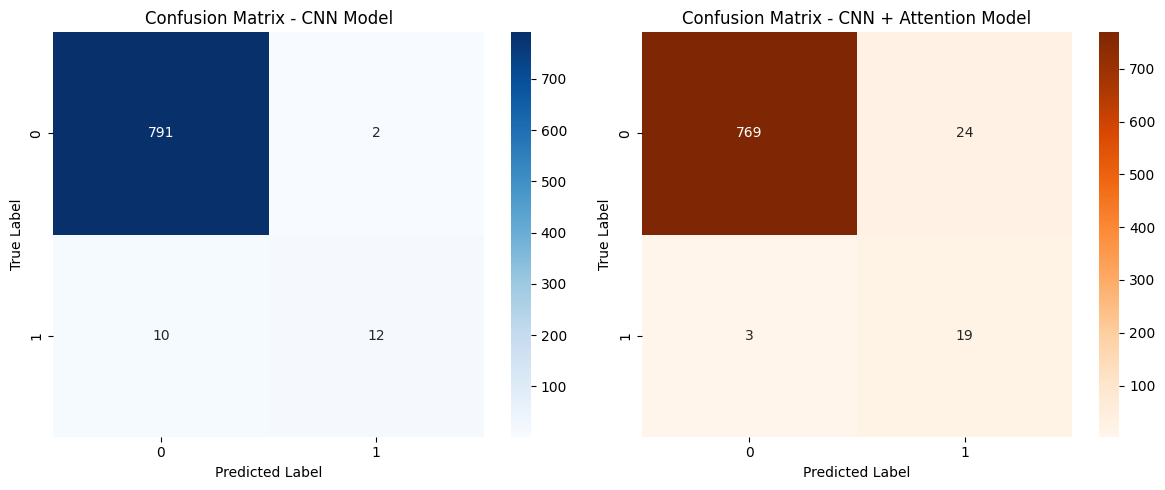

In [876]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred_attention = np.array(y_pred_attention).flatten()
# Convert predictions to binary (0/1) based on threshold
threshold = 0.5
y_pred_cnn_binary = (y_pred_model >= threshold).astype(int)
y_pred_attention_binary = (y_pred_attention >= threshold).astype(int)

# Compute confusion matrices
conf_matrix_cnn = confusion_matrix(y_true, y_pred_cnn_binary)
conf_matrix_attention = confusion_matrix(y_true, y_pred_attention_binary)

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for CNN Model
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Confusion Matrix - CNN Model")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Confusion Matrix for CNN + Attention Model
sns.heatmap(conf_matrix_attention, annot=True, fmt="d", cmap="Oranges", ax=axs[1])
axs[1].set_title("Confusion Matrix - CNN + Attention Model")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# Show the plots
plt.tight_layout()
plt.show()


# Plotting the loss over time

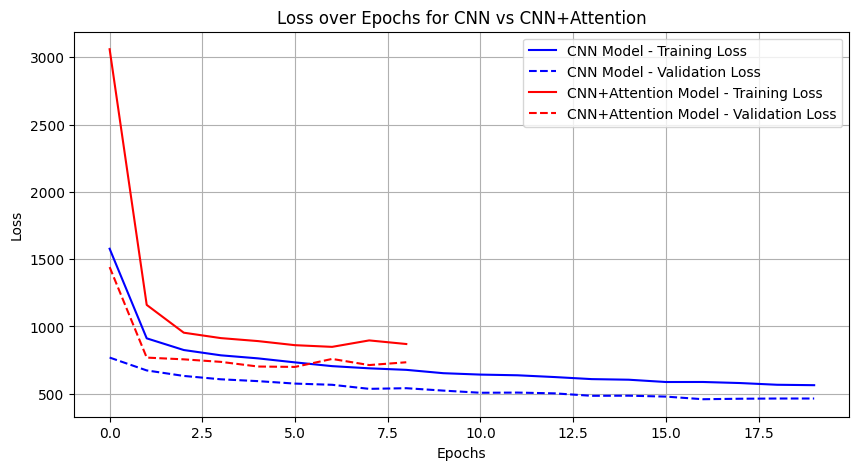

In [768]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(10, 5))

# CNN Model Loss (Blue)
plt.plot(history_cnn.history['loss'], label="CNN Model - Training Loss", linestyle='-', color='blue')
plt.plot(history_cnn.history['val_loss'], label="CNN Model - Validation Loss", linestyle='dashed', color='blue')

# CNN + Attention Model Loss (Green)
plt.plot(history_cnn_attention.history['loss'], label="CNN+Attention Model - Training Loss", linestyle='-', color='red')
plt.plot(history_cnn_attention.history['val_loss'], label="CNN+Attention Model - Validation Loss", linestyle='dashed', color='red')

# Formatting
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs for CNN vs CNN+Attention')
plt.legend()
plt.grid()
plt.show()


# More plots

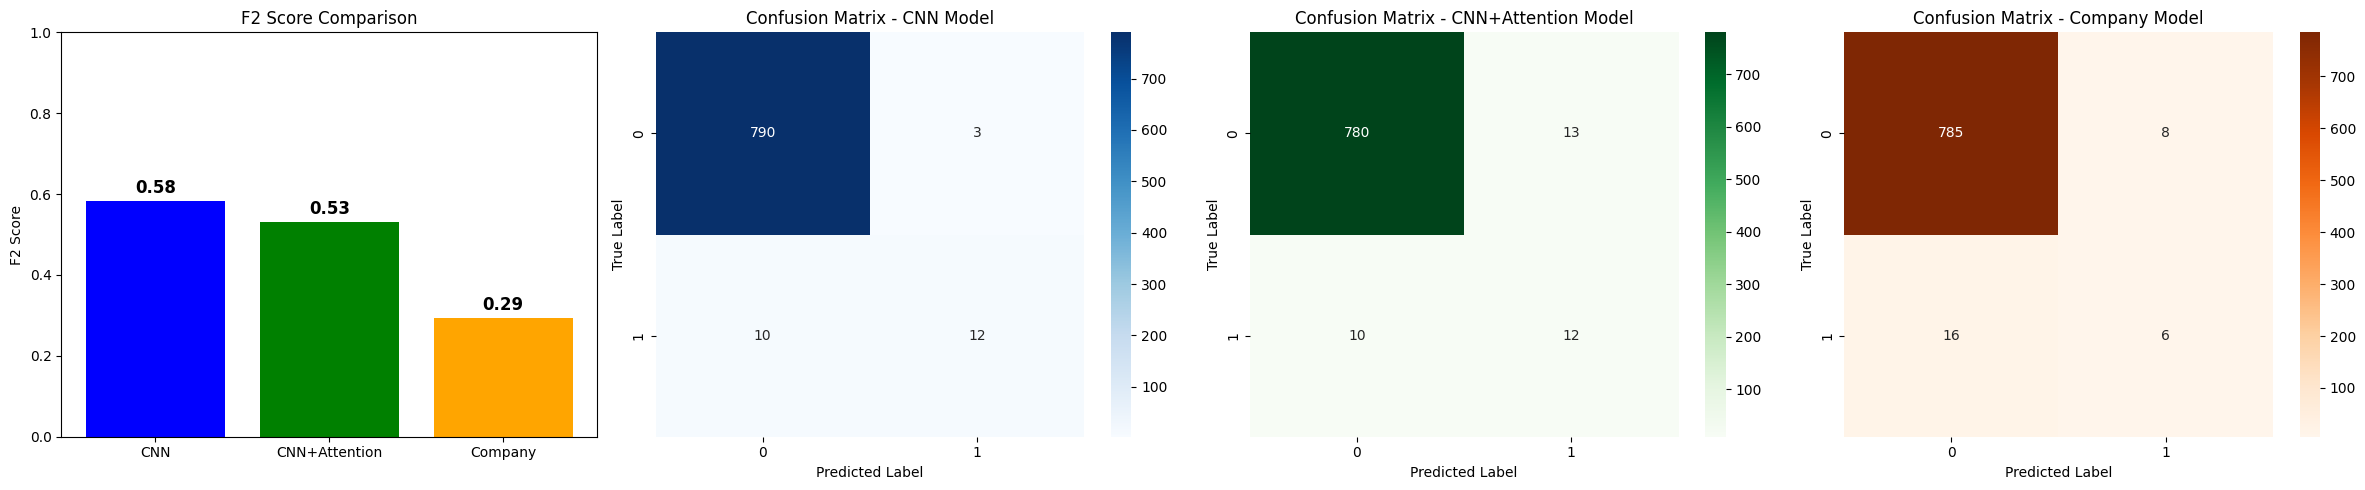

In [769]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrices
conf_matrix_cnn = confusion_matrix(y_true, y_pred_model)  # CNN Model
conf_matrix_attention = confusion_matrix(y_true, y_pred_attention)  # CNN+Attention Model
conf_matrix_company = confusion_matrix(y_true, y_pred_company)  # Company Model

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Bar Chart for F2 Score Comparison
f2_scores = [f2_score_model, f2_score_attention, f2_score_company]
models = ['CNN', 'CNN+Attention', 'Company']
colors = ['blue', 'green', 'orange']

bars = axs[0].bar(models, f2_scores, color=colors)

# Add data labels on top of bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', fontsize=12, fontweight='bold')

axs[0].set_ylabel('F2 Score')
axs[0].set_ylim(0, 1)  # Ensuring the bars are properly visible
axs[0].set_title('F2 Score Comparison')

# Confusion Matrix for CNN Model
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Confusion Matrix - CNN Model")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# Confusion Matrix for CNN+Attention Model
sns.heatmap(conf_matrix_attention, annot=True, fmt="d", cmap="Greens", ax=axs[2])
axs[2].set_title("Confusion Matrix - CNN+Attention Model")
axs[2].set_xlabel("Predicted Label")
axs[2].set_ylabel("True Label")

# Confusion Matrix for Company Model
sns.heatmap(conf_matrix_company, annot=True, fmt="d", cmap="Oranges", ax=axs[3])
axs[3].set_title("Confusion Matrix - Company Model")
axs[3].set_xlabel("Predicted Label")
axs[3].set_ylabel("True Label")

# Show the plots
plt.tight_layout()
plt.show()
